In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from src.scripts.article_to_country import *

from src.data.dataloader import *
from src.utils.plots import *
from src.utils.functions import *
from src.scripts.articles_clicks_links import click_count_in_paths
from country_list import countries_for_language
from itertools import combinations
import plotly.express as px


In [38]:
results = {}
country_data = pd.read_csv('data/country_data.csv', index_col=0)
counts = filter_top_k(country_data, k=2, N=1)
total_number_of_articles = len(counts)

nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")
results["naïve"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles

refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with naive + llama: {len(nan_df)}")
results["naïve + LlaMa"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles

qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
qwen_missing = len(qwen_country_data[qwen_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with QWEN: {qwen_missing}")
results["Qwen"] = (total_number_of_articles - qwen_missing) / total_number_of_articles


llama_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
llama_missing = len(llama_country_data[llama_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with LLAMA: {llama_missing}")
results["LlaMa"] = (total_number_of_articles - llama_missing) / total_number_of_articles

llama_country_data_imporved = pd.read_csv('data/country_data_full_llama_improved.csv', index_col=0)
llama_missing_improved = len(llama_country_data_imporved[llama_country_data_imporved["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with LLAMA: {llama_missing_improved}")
results["LlaMa_improved"] = (total_number_of_articles - llama_missing_improved) / total_number_of_articles


Number of articles with no countries before completion with llama: 1412
Number of articles with no countries after completion with naive + llama: 283
Number of articles with no countries after completion with QWEN: 2905
Number of articles with no countries after completion with LLAMA: 479
Number of articles with no countries after completion with LLAMA: 1345


In [39]:

# qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
# countries = list(dict(countries_for_language('en')).values())

# for idx, row in qwen_country_data.iterrows():
#     if not pd.isna(row['Top_1_name']):
#         for country in countries:
#             if country.lower() in row['Top_1_name'].lower():
#                 qwen_country_data.at[idx, 'Top_1_name'] = country.lower()
#                 break
# qwen_country_data.to_csv('data/country_data_full_qwen.csv')

In [40]:

# qwen_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
# countries = list(dict(countries_for_language('en')).values())

# for idx, row in qwen_country_data.iterrows():
#     if not pd.isna(row['Top_1_name']):
#         for country in countries:
#             if country.lower() in row['Top_1_name'].lower():
#                 qwen_country_data.at[idx, 'Top_1_name'] = country.lower()
#                 break
# qwen_country_data.to_csv('data/country_data_full_llama.csv')

In [41]:
fig = px.bar(x=results.keys(), y=results.values())
fig.update_layout(title="Proportion of articles assigned to a country")
fig.update_yaxes(range=[0, 1])
fig.show()
fig.write_html("test_plt.html")

Text(0, 0.5, '% of articles assigned to a country')

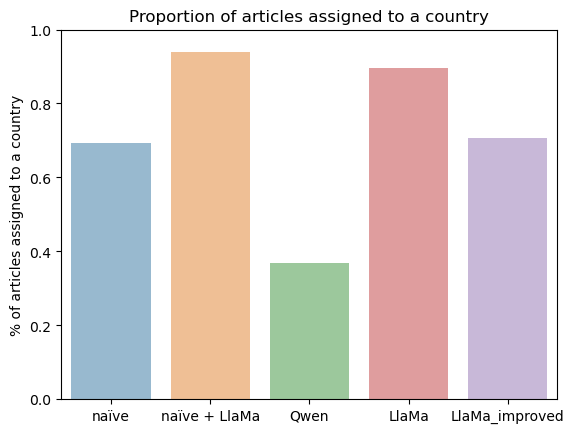

In [42]:
sns.barplot(x=results.keys(), y=results.values(),  alpha=0.5, hue=results.keys(), )
plt.ylim(0, 1)
plt.title("Proportion of articles assigned to a country")
plt.ylabel("% of articles assigned to a country")

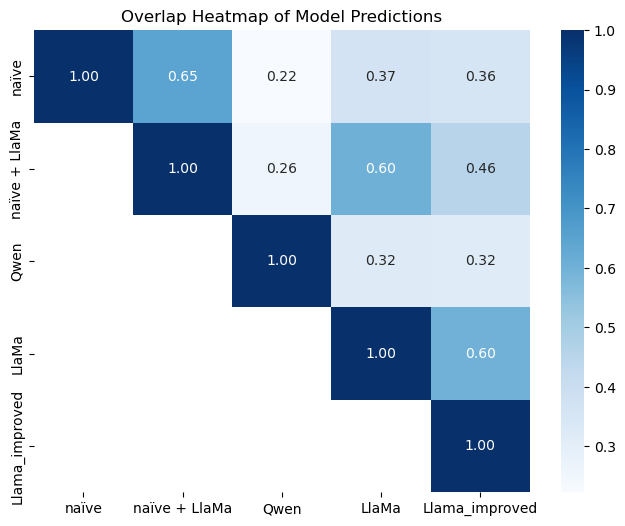

In [43]:
models = {
    "naïve": counts,
    "naïve + LlaMa": refined_data,
    "Qwen": qwen_country_data,
    "LlaMa": llama_country_data,
    "Llama_improved" : llama_country_data_imporved
}

heatmap_data = pd.DataFrame(index=models, columns=models)

for model in models.keys():
    heatmap_data.loc[model, model] = 1.0

for model1, model2 in combinations(models.keys(), 2):
    df_1 = models[model1]
    df_2 = models[model2]
    overlap = (df_1["Top_1_name"] == df_2["Top_1_name"]).sum() / total_number_of_articles
    heatmap_data.loc[model1, model2] = overlap
    # heatmap_data.loc[model2, model1] = overlap

# Convert to float
heatmap_data = heatmap_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Overlap Heatmap of Model Predictions")
plt.show()

In [44]:
articles = pd.DataFrame(counts.index)

subset_1 = articles.sample(10, random_state=0).values.flatten().tolist()
subset_2 = articles.sample(10, random_state=1).values.flatten().tolist()
subset_3 = articles.sample(10, random_state=2).values.flatten().tolist()
subset_4 = articles.sample(10, random_state=3).values.flatten().tolist()
subset_5 = articles.sample(10, random_state=4).values.flatten().tolist()
subset_6 = articles.sample(10, random_state=5).values.flatten().tolist()

In [45]:
claire = subset_1 + subset_3
theo = subset_2 + subset_4
oriane = subset_1 + subset_4
bryan = subset_2 + subset_5
jeremy = subset_3 + subset_5

In [46]:
claire = pd.DataFrame(index=claire, columns=["country"])
theo = pd.DataFrame(index=theo, columns=["country"])
oriane = pd.DataFrame(index=oriane, columns=["country"])
bryan= pd.DataFrame(index=bryan, columns=["country"])
jeremy = pd.DataFrame(index=jeremy, columns=["country"])

In [47]:
# pd.DataFrame(claire).to_csv("claire.csv")
# pd.DataFrame(theo).to_csv("theo.csv")
# pd.DataFrame(oriane).to_csv("oriane.csv")
# pd.DataFrame(bryan).to_csv("bryan.csv")
# pd.DataFrame(jeremy).to_csv("jeremy.csv")

# countries = list(dict(countries_for_language('en')).values())
# pd.DataFrame(countries).to_csv("countries.csv")

In [48]:
annotation_path = "./data/annotated/"

claire = pd.read_csv(annotation_path + "subset_claire.csv", index_col=0, na_values="None")
theo = pd.read_csv(annotation_path + "subset_theo.csv", index_col=0, na_values="None")
oriane = pd.read_csv(annotation_path + "subset_oriane.csv", index_col=0, na_values="None")
bryan = pd.read_csv(annotation_path + "subset_bryan.csv", index_col=0, na_values="None")
jeremy = pd.read_csv(annotation_path + "subset_jeremy.csv", index_col=0, na_values="None")

In [49]:
subset_1_c = claire[:10]
subset_3_c = claire[10:]

subset_2_t = theo[:10]
subset_4_t = theo[10:]

subset_1_o = oriane[:10]
subset_4_o = oriane[10:]

subset_2_b = bryan[:10]
subset_5_b = bryan[10:]

subset_3_j = jeremy[:10]
subset_5_j = jeremy[10:]

In [50]:
comparison1 = subset_1_c["country"].str.lower().fillna("nan") == subset_1_o["country"].str.lower().fillna("nan")
comparison1.sum()

8

In [51]:
comparison2 = subset_2_t["country"].str.lower().fillna("nan") == subset_2_b["country"].str.lower().fillna("nan")
comparison2.sum()

6

In [52]:
comparison3 = subset_3_c["country"].str.lower().fillna("nan") == subset_3_j["country"].str.lower().fillna("nan")
comparison3.sum()

8

In [53]:
comparison4 = subset_4_t["country"].str.lower().fillna("nan") == subset_4_o["country"].str.lower().fillna("nan")
comparison4.sum()

5

In [54]:
comparison5 = subset_5_b["country"].str.lower().fillna("nan") == subset_5_j["country"].str.lower().fillna("nan")
comparison5.sum()

9

In [55]:
df = pd.concat([
    subset_1_c.loc[comparison1],
    subset_2_b.loc[comparison2],
    subset_3_c.loc[comparison3],
    subset_4_t.loc[comparison4],
    subset_5_b.loc[comparison5]
], ignore_index=False)


In [56]:
df.to_csv("data/annotated/consensus.csv")

In [57]:
llama_country_data_imporved.loc[df.index]["Top_1_name"].str.lower().fillna("nan")

Hadrian%27s_Wall                                    nan
Globe_Theatre                            united kingdom
List_of_monarchs_in_the_British_Isles    united kingdom
Aleksandr_Vasilevsky                             russia
Pyongyang                                   north korea
Ivory                                               nan
Beep_%28SWBLW%29                          united states
Fermium                                             nan
Dwight_D._Eisenhower                      united states
Invasion                                        grenada
Scooby-Doo                                united states
Bill_Clinton                              united states
Frederick_Douglass                        united states
Cambrian_explosion                                china
CPU_cache                                           nan
Cathedral_of_Magdeburg                          germany
Anna_Karenina                                    russia
Eurasian_Bullfinch                              

In [58]:
models = {
    "naïve": counts,
    "naïve + LlaMa": refined_data,
    "Qwen": qwen_country_data,
    "LlaMa": llama_country_data,
    "Llama_imptoved" : llama_country_data_imporved
}

values = []
for model in models.keys():
    agreement_value = (models[model].loc[df.index]["Top_1_name"].str.lower().fillna("nan") == df["country"].str.lower().fillna("nan")).sum() / len(df)
    values.append(agreement_value)
    
px.bar(
    x=models.keys(), 
    y=values, 
    color=models.keys(),
    title="Agreement between annotators and models", 
    labels={"x": "Model", "y": "Agreement"}
    ).update_yaxes(range=[0, 1]).show()

    

<div class="alert alert-success"> <strong>First glance at the distribution of knowledge worldwide :</strong> 

- Assign a country to each article
- Try different methods and see how many articles can be classified
- Verify these classification with human annotation 
- Select the best method for further analysis of the dataset

</div> <div class="alert alert-warning">  <strong>Countries :</strong>

In order to classify countries we used the standar ISO list with 249 countries and the following distribution: 
- UN Members: 193
- UN Observer States: 2
- States With Partial Recognition: 2
- Inhabited Dependent Territories: 45
- Uninhabited Territories: 6
- Antarctica: 1
</div>

A naïve method was employed to classify articles to specific countries by performing a text search to identify occurrences of country names within the plaintext. This approach utilized basic regular expression matching to analyze the articles. However, it resulted in approximately 31% of the articles (1,412 out of 4,604) remaining unclassified, highlighting significant limitations.

### Identified Issues with the Approach:
1. **Over-classification on mentioned country names**: 
   The presence of a country name in an article does not necessarily imply that the article belongs to that country. This assumption leads to inaccuracies in classification.

2. **Lack of contextual understanding**: 
   The text search method lacks the ability to discern the context in which a country name appears, resulting in potential misclassifications.

3. **Observations**: 
   A review of the articles revealed a lot of incorrect or missing classifications. For example:
   - The article *13th Century* was missclassified under China due to mentions of events occurring there during that period, despite the article lacking any specific association with China.
   - Conversely, the article *4-2-0*, which details a type of railroad in the United States, was left unclassified despite its clear appartenance to that country.

These findings show the limitations of the current text-matching methodology and highlight the need for a more robust, context-aware approach to accurately classify articles.

Given the limitations of the initial text-search-based approach, a decision was made to use Large Language Models (LLMs) to enhance the article classification process. LLMs, with their extensive general knowledge, have the capability to analyze articles and respond to queries with a deeper understanding. 

Unlike simple text searches, LLMs not only utilize the content of the article but also incorporate their pre-existing (trained) knowledge. This contextual understanding should enables more accurate classification.

By employing LLMs, two potential strategies can be pursued:
1. **Targeted classification of previously unclassified articles**: The 1,412 articles that remained unclassified under the initial approach can be reevaluated, allowing for a significant reduction in the unclassified proportion. After this step only 6% (283 out of 4604) were not classified.

2. **Full Reclassification**: LLMs can be used to perform a complete reclassification of all articles, eliminating the biases and limitations inherent in the original text-search methodology. In order to test this two existing LLMs were used : [LLaMa](https://www.llama.com/) and [Qwen](https://qwen-ai.com/). These powerful models, with less than 8 billion parameters, offer significant computational efficiency and can be run locally on consumer hardware, making them accessible and cost-effective solutions compared to bigger models like ChatGPT and their paid API.

This transition to LLM-based classification is expected to significantly improve the accuracy and reliability of the country assignment process.

The prompt used in order to make the models classify the articles was in the following format : 



METHODS  : 

DOWNSIDES : 